In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

# Load Dataset

In [2]:
item_to_id = pd.read_csv('item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [4]:
item_to_id.nunique()

Item_name    48
Item_id      48
dtype: int64

In [5]:
history = pd.read_csv('purchase_history.csv')
history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [6]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [7]:
history.nunique()

user_id    24885
id         37309
dtype: int64

# Data Processing

In [8]:
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1,49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index = list(range(1,49)))

In [9]:
# get user_item count matrix

user_item_count = history.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Question 1

**The customer who bought the most items overall in her lifetime**

In [20]:
user_count = user_item_count.sum(axis = 1).reset_index().rename(columns = {0:'count'})
user_count.sort_values(by = 'count', ascending = False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


So the customer who bought the most items is 269335 with 72 items

**For each item, the customer who bought that product the most**

In [21]:
item_user_most = user_item_count.apply(np.argmax, axis = 0).reset_index()
item_user_most = item_user_most.rename(columns = {'index': 'Item_id', 0: 'User_id'})

df = pd.merge(left = item_user_most, right = item_to_id, on = 'Item_id', how = 'left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,512
1,2,lettuce,512
2,3,pet items,2552
3,4,baby items,92
4,5,waffles,3605
5,6,poultry,5555
6,7,sandwich bags,2926
7,8,butter,2493
8,9,soda,4445
9,10,carrots,10238


# Question 2

In [23]:
# Define the feature matrix: item_id, user_id

feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
# determine the best number of clusters

clusters = range(2,30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

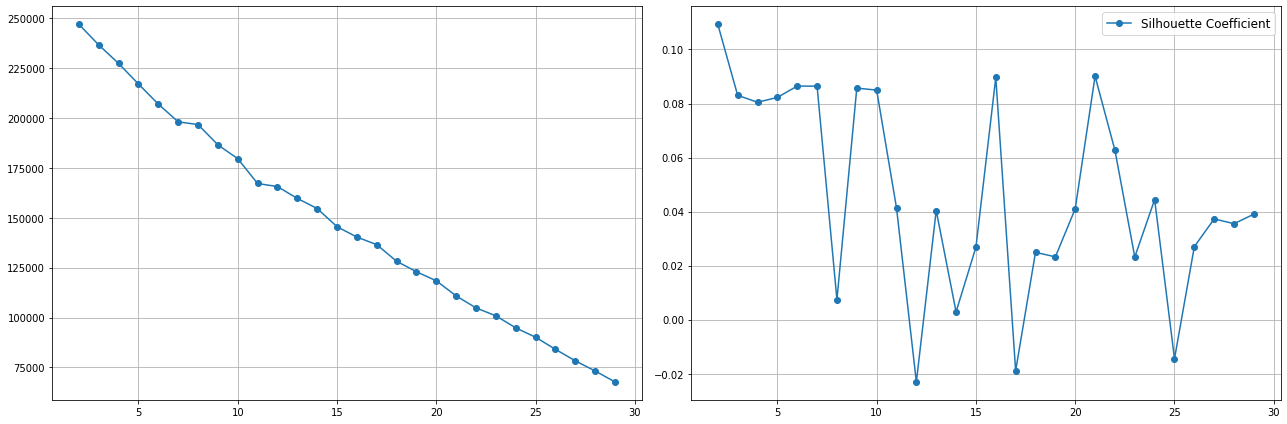

In [27]:
# Visualization

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
ax[0].plot(clusters, inertias, 'o-', label = 'Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label = 'Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

It seems 12 clusters is the best choice. Now, let's apply PCA on the data and visualize the data

In [28]:
# Build K-Means model

kmeans = KMeans(n_clusters = 12, init = 'k-means++', random_state = 42)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [29]:
# PCA for dimension reduction

pca = PCA(n_components = 2, random_state = 42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

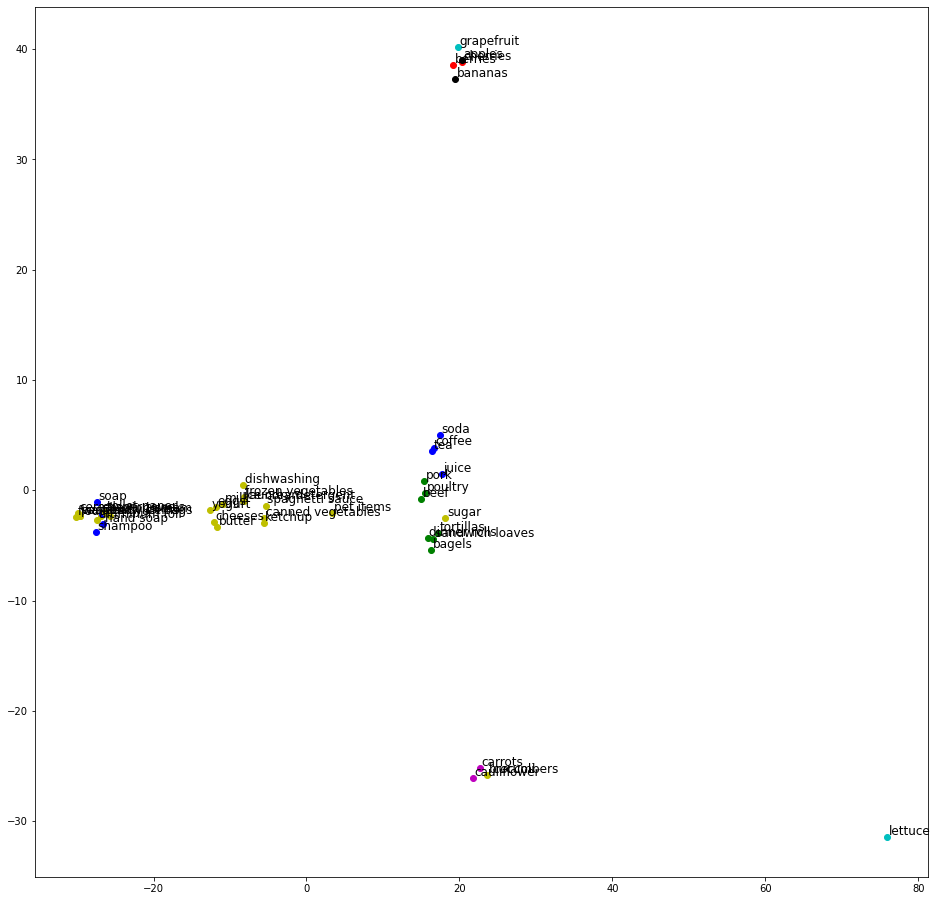

In [32]:
# Visualization in 2D

colors = ['b','g','r','c','m','y','k','w']

fig, ax = plt.subplots(figsize = (16,16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x,y,'o',color = colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j+1]['Item_name']
    ax.annotate(xy =(x+0.2, y+0.2), text=name.values[0], fontsize = 12)
    
plt.show()

In [33]:
# print useful information
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['shampoo', 'shaving cream', 'hand soap', 'soap']
1 	 ['bagels', 'tortillas', 'dinner rolls', 'sandwich loaves']
2 	 ['cherries']
3 	 ['lettuce']
4 	 ['carrots', 'cauliflower']
5 	 ['sugar', 'pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'cereals', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'flour', 'pasta', 'toilet paper', 'ice cream', 'ketchup', 'broccoli', 'yogurt']
6 	 ['apples', 'bananas']
7 	 ['cucumbers']
8 	 ['soda', 'tea', 'juice', 'coffee']
9 	 ['poultry', 'beef', 'pork']
10 	 ['berries']
11 	 ['grapefruit']
12 	 []
13 	 []
14 	 []
15 	 []
16 	 []
17 	 []
18 	 []
19 	 []
20 	 []
